# Accessing TensorBoard Data as DataFrames

## Overview

TensorBoard的主要特点是其交互式GUI。然而，用户有时希望以编程方式读取存储在TensorBoard中的数据日志，例如执行事后分析和创建日志数据的自定义可视化。

TensorBoard 2.3 通过 `tensorboard.data.experimental.ExperimentFromDev()` 支持此用例。它允许以编程方式访问 TensorBoard 的标量日志。本页面演示了这个新API的基本用法。

> - 正如其API命名空间所反映的那样，该API仍处于实验阶段。这意味着API将来可能会发生中断更改。
> - 目前，此功能仅支持上传到 TensorBoard.dev 的日志记录器，TensorBoard.dev 是一项用于持久化和共享 TensorBoard 的免费托管服务。将来将增加对本地存储的TensorBoard logdir的支持。简而言之，您可以使用一行命令将本地文件系统的TensorBoard logdir 上传到 TensorBoard.dev : `tensorboard dev upload --logdir <logdir>`。有关更多详细信息，请参阅 tensorboard.dev 上的文档。

## Setup

为了使用编程API，请确保将 `pandas` 与 `tensorboard` 一起安装。

在本指南中，我们将使用 `matplotlib` 和 `seaborn` 进行自定义绘图，但您可以选择你喜欢的工具来分析和可视化 `DataFrame`。


In [1]:
!pip install tensorboard pandas
!pip install matplotlib seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 388.3 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 380.9 kB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-macos 2.6.0 requires numpy~=1.19.2, but you have numpy 1.22.3 which is incompatible.
  Using cached matplotlib-3.5.1-cp38-cp38-macosx_11_0_arm64.whl (7.2 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.8/292.8 KB 1.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.4/899.4 KB 268.9 kB/s eta 0:00:0000:0100:01
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.3/59.3 KB 226.1 kB/s eta 0:00:00a 0:00

In [2]:
from packaging import version

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import tensorboard as tb

In [4]:
major_ver, minor_ver, _ = version.parse(tb.__version__).release
assert major_ver >= 2 and minor_ver >= 3, \
    "This notebook requires Tensorboard 2.3 or later."
print("Tensorboard version: ", tb.__version__)

Tensorboard version:  2.6.0


## Loading TensorBoard scalars as a `pandas.DataFrame`

一旦 TensorBoard 日志上传到TensorBoard.dev，它就变成了我们所说的 `experiment` 。每个 `experiment` 都有一个唯一的ID，可以在实验的 TensorBoard.dev URL中找到。对于下面的演示，我们将使用TensorBoard.dev [https://tensorboard.dev/experiment/c1KCv3X3QvGwaXfgX1c4tg](https://tensorboard.dev/experiment/c1KCv3X3QvGwaXfgX1c4tg) 实验：

In [7]:
experiment_id = "c1KCv3X3QvGwaXfgX1c4tg"
experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
df = experiment.get_scalars()
df

,run,tag,step,value
0,"adam,run_1/train",epoch_accuracy,0,0.966867
1,"adam,run_1/train",epoch_accuracy,1,0.986283
2,"adam,run_1/train",epoch_accuracy,2,0.989333
3,"adam,run_1/train",epoch_accuracy,3,0.991933
4,"adam,run_1/train",epoch_accuracy,4,0.991733
...,...,...,...,...
1195,"sgd,run_5/validation",epoch_loss,15,0.020157
1196,"sgd,run_5/validation",epoch_loss,16,0.020212
1197,"sgd,run_5/validation",epoch_loss,17,0.020364
1198,"sgd,run_5/validation",epoch_loss,18,0.022192


`df` 是 `pandas.DataFrame`, 其包含了该实验所有标量记录。

`DataFrame` 的列是：

- `run`: 每次运行都对应于原始 logdir 的子目录。在本实验中，每次 run 都是在给定优化器类型（训练超参数）的MNIST数据集上对卷积神经网络（CNN）的完整训练。此DataFrame包含多个此类 run，这些 runs 对应于不同优化器类型的重复训练运行。
- `tag`: 这描述了同一行中的值是什么意思，即该值在行中代表什么指标。在这个实验中，我们只有两个唯一的 `tag`：分别用于准确性的 `epoch_accuracy` 和损失指标`epoch_loss`。
- `step`：这是一个数字，反映了相应行在 run 中的串行顺序。这里的 `step` 实际上指的是 epoch 数。如果您希望获得 `steo` 值之外的时间戳，您可以在调用`get_scalars()` 时使用关键字参数 `include_wall_time=True`。
- `value`: 这是感兴趣的参数的实际数值。如上所述，此 `DataFrame` 中的每个值要么是损失，要么是准确性，具体取决于行的 `tag`。


In [8]:
print(df['run'].unique())
print(df['tag'].unique())

['adam,run_1/train' 'adam,run_1/validation' 'adam,run_2/train'
 'adam,run_2/validation' 'adam,run_3/train' 'adam,run_3/validation'
 'adam,run_4/train' 'adam,run_4/validation' 'adam,run_5/train'
 'adam,run_5/validation' 'rmsprop,run_1/train' 'rmsprop,run_1/validation'
 'rmsprop,run_2/train' 'rmsprop,run_2/validation' 'rmsprop,run_3/train'
 'rmsprop,run_3/validation' 'rmsprop,run_4/train'
 'rmsprop,run_4/validation' 'rmsprop,run_5/train'
 'rmsprop,run_5/validation' 'sgd,run_1/train' 'sgd,run_1/validation'
 'sgd,run_2/train' 'sgd,run_2/validation' 'sgd,run_3/train'
 'sgd,run_3/validation' 'sgd,run_4/train' 'sgd,run_4/validation'
 'sgd,run_5/train' 'sgd,run_5/validation']
['epoch_accuracy' 'epoch_loss']


## Getting a pivoted (wide-form) DataFrame

在我们的实验中，两个标签（ `epoch_loss` 和 `epoch_accuracy` ）在每次 run 中都在同一组 step 中出现。这使得使用 `pivot=True` 关键字参数直接从`get_scalars()` 获得 “wide-form” `DataFrame` 成为可能。 “wide-form” 的DataFrame的所有标签都包含在DataFrame的列中，在某些情况下使用起来更方便。

In [10]:
dfw = experiment.get_scalars(pivot=True)
dfw

,run,step,epoch_accuracy,epoch_loss
0,"adam,run_1/train",0,0.966867,0.110196
1,"adam,run_1/train",1,0.986283,0.042437
2,"adam,run_1/train",2,0.989333,0.032622
3,"adam,run_1/train",3,0.991933,0.026121
4,"adam,run_1/train",4,0.991733,0.024742
...,...,...,...,...
595,"sgd,run_5/validation",15,0.993800,0.020157
596,"sgd,run_5/validation",16,0.993500,0.020212
597,"sgd,run_5/validation",17,0.993800,0.020364
598,"sgd,run_5/validation",18,0.993100,0.022192


请注意， wide-form 的DataFrame没有一个 `value` 列，而是显式地包含两个`tag`(metric)作为其列：`epoch_accuracy` 和 `epoch_loss`。

## Saving the DataFrame as CSV

`pandas.DataFrame` 与 CSV 具有良好的互操作性。您可以将其存储为本地 CSV 文件，稍后再加载。例如：

In [13]:
csv_path = '/tmp/tb_experiment_1.csv'
dfw.to_csv(csv_path, index=False)
dfw_roundtrip = pd.read_csv(csv_path)
pd.testing.assert_frame_equal(dfw_roundtrip, dfw)

## Performing custom visualization and statistical analysis

Text(0.5, 1.0, 'loss')

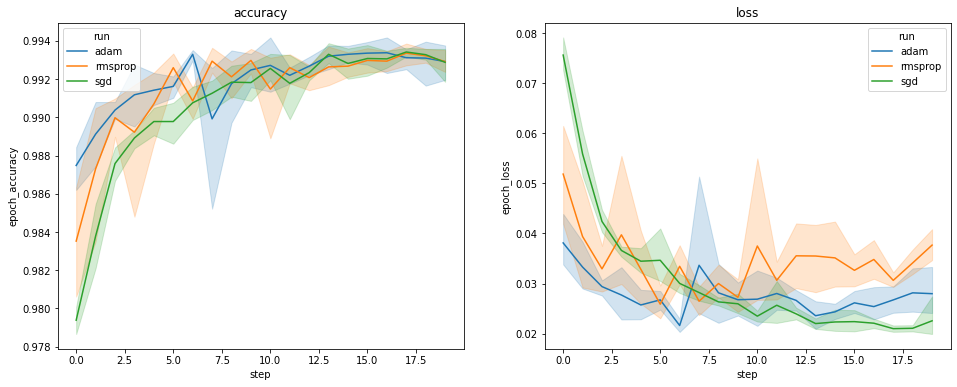

In [15]:
dfw_validation = dfw[dfw.run.str.endswith("/validation")]
optimizer_validation = dfw_validation.run.apply(lambda run: run.split(",")[0])

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.lineplot(data=dfw_validation, x="step", y="epoch_accuracy",
             hue=optimizer_validation).set_title("accuracy")
plt.subplot(1, 2, 2)
sns.lineplot(data=dfw_validation, x="step", y="epoch_loss",
             hue=optimizer_validation).set_title("loss")

上面的图显示了验证准确性和验证损失的时间过程。每条曲线显示优化器类型下5次 run 的平均值。由于seaborn.lineplot()的内置功能，每条曲线还围绕平均值显示±1标准差，这让我们清楚地了解了这些曲线的可变性以及三种优化器类型之间差异的重要性。TensorBoard的GUI尚未支持这种可变性的可视化。

我们想研究 “adam”、“rmsprop”和“sgd”优化器中最小验证损失差异 的想法。因此，我们提取一个 `DataFrame`，以获得每个优化器下的最低验证损失。

然后，我们制作一个框图，以可视化最小验证损失的差异。

<AxesSubplot:xlabel='run', ylabel='epoch_loss'>

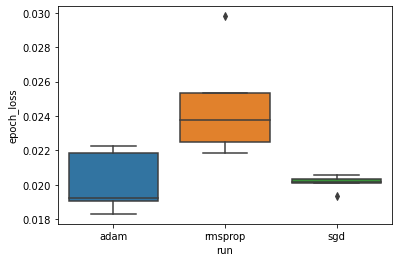

In [17]:
adam_min_val_loss = dfw_validation.loc[optimizer_validation=="adam", :].groupby("run", as_index=False).agg({"epoch_loss":"min"})
rmsprop_min_val_loss = dfw_validation.loc[optimizer_validation=="rmsprop", :].groupby("run", as_index=False).agg({"epoch_loss":"min"})
sgd_min_val_loss = dfw_validation.loc[optimizer_validation=="sgd", :].groupby("run", as_index=False).agg({"epoch_loss": "min"})
min_val_loss = pd.concat([adam_min_val_loss, rmsprop_min_val_loss, sgd_min_val_loss])

sns.boxplot(data=min_val_loss, y="epoch_loss", x=min_val_loss.run.apply(lambda run: run.split(",")[0]))

In [19]:
# Perform pairwise comparisons between the minimum validation losses
# from the three optimizers.
_, p_adam_vs_rmsprop = stats.ttest_ind(
    adam_min_val_loss["epoch_loss"],
    rmsprop_min_val_loss["epoch_loss"])
_, p_adam_vs_sgd = stats.ttest_ind(
    adam_min_val_loss["epoch_loss"],
    sgd_min_val_loss["epoch_loss"])
_, p_rmsprop_vs_sgd = stats.ttest_ind(
    rmsprop_min_val_loss["epoch_loss"],
    sgd_min_val_loss["epoch_loss"])
print("adam vs. rmsprop: p = %.4f" % p_adam_vs_rmsprop)
print("adam vs. sgd: p = %.4f" % p_adam_vs_sgd)
print("rmsprop vs. sgd: p = %.4f" % p_rmsprop_vs_sgd)

adam vs. rmsprop: p = 0.0244
adam vs. sgd: p = 0.9749
rmsprop vs. sgd: p = 0.0135


因此，在0.05的显著水平上，我们的分析证实了我们的假设，即与我们实验中包含的其他两个优化器相比，rmsprop优化器的最小验证损失要高得多（即更糟）。

总之，本教程提供了一个如何从 `TensorBoard.dev` 以 `pandas.DataFrames` 身份访问标量数据的示例。它演示了您可以使用 `DataFrames` 进行灵活而强大的分析和可视化。